# **PHYS 481 - Computational Physics II**

## **Assignment #8 - Poisson's Equation**

### **NAME:** Scott Salmon

### **UCID:** 30093320

### **FILE:** a8_scottsalmon

### **DATES:** 2024/11/30 - 2024/12/04

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Question 1: [8 pts]

Two infinitely long grounded metal plates lie parallel to the $𝑥𝑧$ plane, one at $𝑦 = 0$, the other at $𝑦 = 𝑎 = 5 cm$. They are connected at $𝑥 = \pm 𝑏 = \pm 4 cm$ by narrower metal strips maintained at a constant potential $𝑉_0 = 4$ Volts to form a rectangular channel. A thin layer of insulation at each corner allows the sides to be maintained at different potentials.

An analytic solution to this boundary value problem can be obtained through separation of variables as:

$$V(x,y) = \frac{4V_0}{n}\sum_{n=1,3,5...}\frac{1}{n}\frac{cosh(n\pi x/a)}{cosh(n\pi b/a)} sin(n\pi y/a) $$

Plot a contour plot of the analytic result, using contours from 0 to 4V in steps of 0.1V. Label the contour lines legibly.

WARNING: you will need a very large number of terms to get an accurate answer (order 103 or so), and the higher-order terms involve the ratio of two extremely large numbers. You will need to rearrange the analytic result into a more tractable form to prevent overflow.

#### **Formula Rearrangement:**

We know that: 

$$cosh(z) = \frac{e^z + e^{-z}}{2}$$

Therefore, the $cosh(n\pi x/a)$ becomes:

$$cosh(n\pi x/a) = \frac{e^{n\pi x/a} + e^{-n\pi x/a}}{2}$$

And likewise, the $cosh(n\pi x/b)$ becomes:

$$cosh(n\pi x/b) = \frac{e^{n\pi x/b} + e^{-n\pi x/b}}{2}$$

If we substitute this into our original formula...

$$\frac{cosh(n\pi x/a)}{cosh(n\pi x/b)} = \frac{\frac{e^{n\pi x/a} + e^{-n\pi x/a}}{2}}{\frac{e^{n\pi x/b} + e^{-n\pi x/b}}{2}}$$
$$\frac{cosh(n\pi x/a)}{cosh(n\pi x/b)} = \frac{e^{n\pi x/a} + e^{-n\pi x/a}}{e^{n\pi x/b} + e^{-n\pi x/b}}$$

Then divide the numerator and denominator by $e^{n\pi b/a}$:

$$\frac{cosh(n\pi x/a)}{cosh(n\pi x/b)} = \frac{e^{(n\pi x/a) - (n\pi b/a)} + e^{(-n\pi x/a) - (n\pi b/a)}}{1+e^{-2n\pi b/a}}$$

And now substitute it back into our series equation:

$$V(x,y) = \frac{4V_0}{\pi} \sum_{1,3,5,...} \frac{1}{n} \frac{exp(n\pi x/a - n\pi b/a) + exp{(-n\pi x/a - n\pi b/a)}}{1+exp(-2n\pi b/a)}sin(n\pi y/a)$$

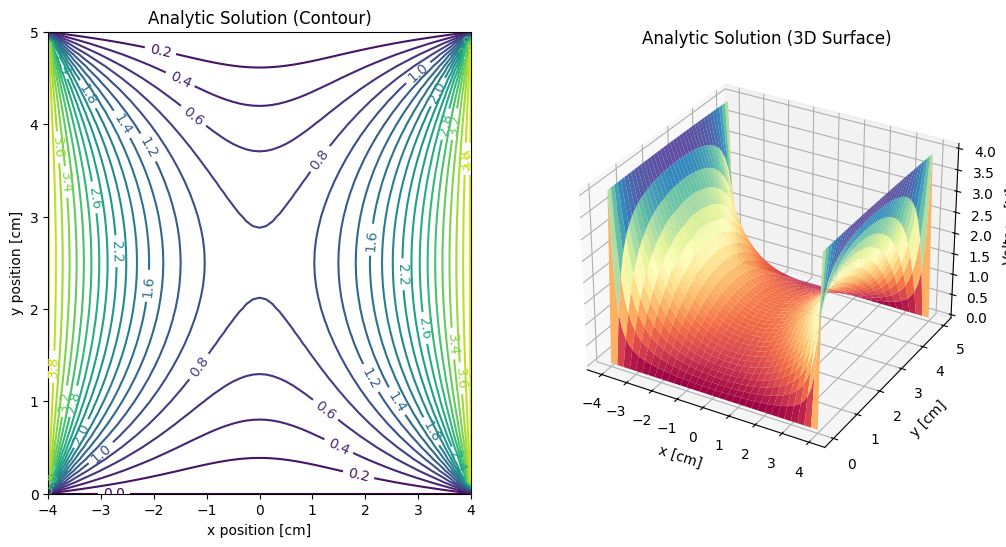

In [2]:
def analytic():

    '''Uses the series equation depicted above to solve this boundary value problem. Instead of using cosh functions directly,
    an altered but equivalent form using exponentials was used to prevent overflow from occuring. After solving the problem,
    the results are displayed in a subplot as both a contour and as a 3D surface. The XYZ values are also returned for later use.
    -----------------------------------------------------------------------------------------------------------------
    Parameters: None
    Returns: X and Y meshgrids, and Voltage values
    '''
    
    #constants
    V0 = 4 #volts
    a = 5 #5cm
    b = 4 #4cm
    terms = 10000
    
    #ratio should to be ~~ 2:1 to keep dx=dy
    num_x = 65
    num_y = 41

    #initializing arrays
    x_values = np.linspace(-b,b,num_x)
    y_values = np.linspace(0,a,num_y)
    X, Y = np.meshgrid(x_values, y_values)
    V = np.zeros((num_y,num_x))
    n_terms = np.arange(1, terms, 2)
    
    #summation loop
    total = 0
    for n in n_terms:
        term = (np.exp(n*np.pi*X/a-n*np.pi*b/a)+np.exp(-n*np.pi*X/a-n*np.pi*b/a))/(1+np.exp(-2*n*np.pi*b/a-n*np.pi*b/a))  
        total = total + (1/n)*term * np.sin(n * np.pi * Y / a)
    
    #analytic formula    
    V = (4*V0/np.pi)*total

    #Create subplots
    fig = plt.figure(figsize=(12, 6))

    #Plot contour in the first subplot
    ax1 = fig.add_subplot(121)
    anal = ax1.contour(X, Y, V, levels=20)
    ax1.clabel(anal, inline=True, fontsize=10)
    ax1.set_xlabel('x position [cm]')
    ax1.set_ylabel('y position [cm]')
    ax1.set_title('Analytic Solution (Contour)')

    #Plot 3D surface in the second subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, V, cmap='Spectral', linewidth=0, antialiased=True)
    ax2.set_xlabel('x [cm]')
    ax2.set_ylabel('y [cm]')
    ax2.set_zlabel('Voltage [V]')
    ax2.set_title('Analytic Solution (3D Surface)')
    
    return X, Y, V
    
X1, Y1, V1 = analytic()

### Question 2: [8 pts]

Repeat Q1 numerically using Jacobi iteration. Plot a contour plot of the potential and compare to the analytic result (i.e. contour plots of both the numerical solution and the absolute difference between the numerical and analytic solutions).

The maxiumum difference between the two methods was 0.03317, or 0.82%.
The average difference between the two methods was 0.00776, or 0.57%.


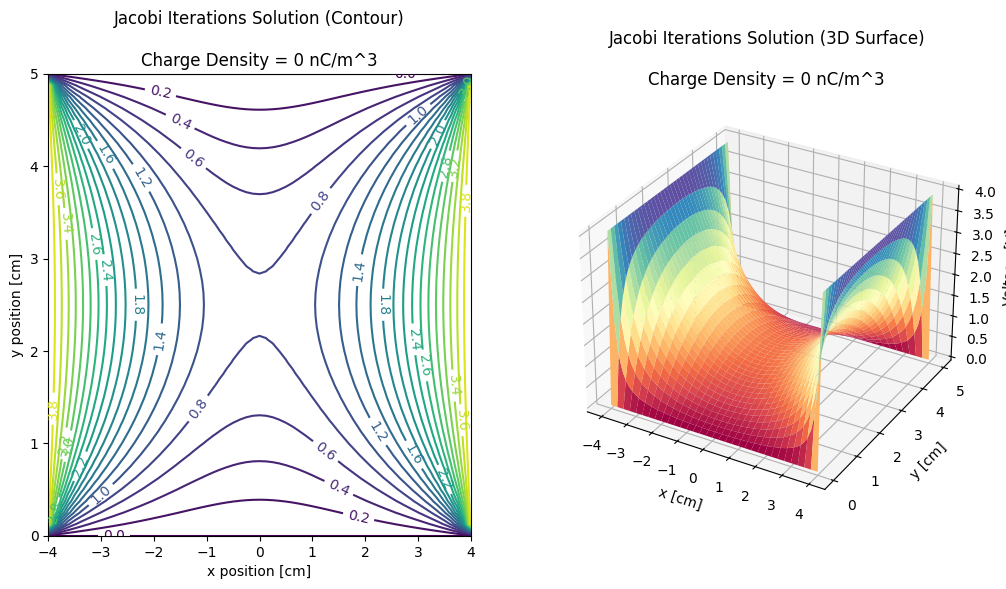

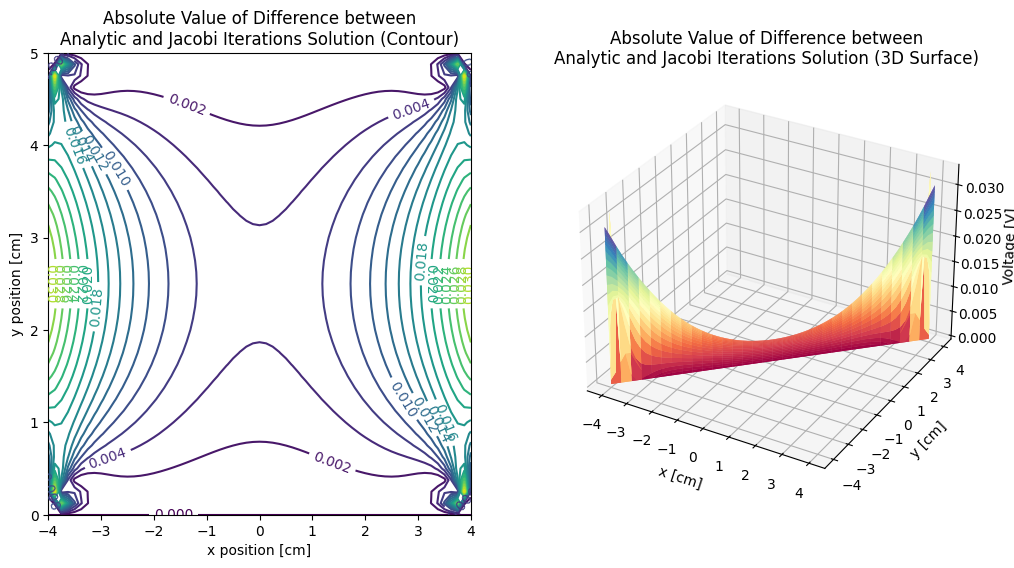

In [ ]:
def jacobi(charge):
    
    '''Takes a different approach to solving the same problem. Instead of starting with an analytical equation, for this function we
    will use Jacobi iterations. The general idea of how this works is that we'll initialize our grid with the boundary conditions and 
    then we will allow the program to iterate 100k times, slowly adjusting the voltage distribution by taking the average of every 4 points 
    and reassigning values. The only unchanged values will be at the boundaries. As time progresses, the correct potential distribution will
    be created.

    This function finally makes a contour plot and 3D surface plot to visualize the determined values. The XYZ values are returned for later use.
    -----------------------------------------------------------------------------------------------------------------
    Parameters: Charge (float) - the desired charge density in C/cm^3
    Returns: X and Y meshgrids, and Voltage values (tuple)
    '''

    #constants
    V0 = 4 #volts
    a = 5 #5cm
    b = 4 #4cm
    max_iterations=100000
    E_0 = 8.854e-14 #8.854e-14 F/cm

    #ratio should to be ~~ 8:5 to keep dx=dy. Also should be odd so there is an exact center point
    num_x = 65
    num_y = 41
    dx = 8/(num_x-1) #finds dx in cm
    
    #initializing arrays
    x_values = np.linspace(-b,b,num_x)
    y_values = np.linspace(0,a,num_y)
    X, Y = np.meshgrid(x_values, y_values)
    density = np.zeros((num_y,num_x)) + ( (charge*(dx**2)) / (4*E_0) )
    
    #initialize potential grid (with boundary conditions)
    V = np.zeros((num_y,num_x))
    V[:,0] = V0
    V[:,-1] = V0
    V[-1,:]  = 0
    V[0,:] = 0
    
    #Update potential using the Jacobi formula
    #Update rule: V_(i,j) = 0.25 [ V_(i+1,j) + V_(i-1,j) + V_(i,j+1) + V_(i,j-1) ] + (p*dx^2)/(4*e_0)
    for _ in range(max_iterations):
        V[1:-1,1:-1]= 0.25*(V[0:-2,1:-1]+V[2:,1:-1]+V[1:-1,0:-2]+V[1:-1,2:]) + density[1:-1, 1:-1]
    
    #Create subplots
    fig = plt.figure(figsize=(12, 6))

    #Plot contour in the first subplot
    ax1 = fig.add_subplot(121)
    anal = ax1.contour(X, Y, V, levels=25)
    ax1.clabel(anal, inline=True, fontsize=10)
    ax1.set_xlabel('x position [cm]')
    ax1.set_ylabel('y position [cm]')
    ax1.set_title('Jacobi Iterations Solution (Contour)\n\nCharge Density = %i nC/m^3'%(charge*(10**15)))

    #Plot 3D surface in the second subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, V, cmap='Spectral', linewidth=0, antialiased=True)
    ax2.set_xlabel('x [cm]')
    ax2.set_ylabel('y [cm]')
    ax2.set_zlabel('Voltage [V]')
    ax2.set_title('Jacobi Iterations Solution (3D Surface)\n\nCharge Density = %i nC/m^3'%(charge*(10**15)))
    
    return X, Y, V

def comparison(x1,x2,y1,y2,v1,v2, question='q2'):
    
    '''This function is used to compare the results from one of the solutions to another solution. It takes in the X, Y and V values for
    each plot, and then has a desired question setting that is used to change the plots depending on the question this function is being
    used in.
    -----------------------------------------------------------------------------------------------------------------
    Parameters: x1,x2,y1,y2,v1,v2 meshgrids and voltage values, and question='q2' or 'q4'
    Returns: None
    '''

    #this is ensuring the X=X and Y=Y for meshgrid size
    if x1.all() == x2.all() and y1.all() == y2.all():

        #finds absolute value of difference
        V = np.abs(v1-v2)
        
        #finds max difference between two methods
        maximum = np.max(np.abs(v1-v2))
        ref = np.max(v1)
        percentage = (maximum/ref)*100
        
        #finds average difference between two methods
        average = np.mean(np.abs(v1-v2))
        reference = np.mean(v1)
        percent = (average/reference)*100
        
        if question=='q2':
        
            print("The maxiumum difference between the two methods was %0.5f, or %0.2f%%."%(maximum, percentage))
            print("The average difference between the two methods was %0.5f, or %0.2f%%."%(average, percent))
            
            #Create subplots
            fig = plt.figure(figsize=(12, 6))

            #Plot contour in the first subplot
            ax1 = fig.add_subplot(121)
            anal = ax1.contour(x1, y1, V, levels=20)
            ax1.clabel(anal, inline=True, fontsize=10)
            ax1.set_xlabel('x position [cm]')
            ax1.set_ylabel('y position [cm]')
            ax1.set_title('Absolute Value of Difference between\nAnalytic and Jacobi Iterations Solution (Contour)')

            #Plot 3D surface in the second subplot
            ax2 = fig.add_subplot(122, projection='3d')
            ax2.plot_surface(x1, x1, V, cmap='Spectral', linewidth=0, antialiased=True)
            ax2.set_xlabel('x [cm]')
            ax2.set_ylabel('y [cm]')
            ax2.set_zlabel('Voltage [V]')
            ax2.set_title('Absolute Value of Difference between\nAnalytic and Jacobi Iterations Solution (3D Surface)')
        
        else:
            print("The maxiumum difference between the two methods was %e, or %e%%."%(maximum, percentage))
            print("The average difference between the two methods was %e, or %e%%."%(average, percent))
            
            #Create subplots
            fig = plt.figure(figsize=(12, 6))

            #Plot contour in the first subplot
            ax1 = fig.add_subplot(121)
            anal = ax1.contour(x1, y1, V, levels=20)
            ax1.clabel(anal, inline=True, fontsize=10)
            ax1.set_xlabel('x position [cm]')
            ax1.set_ylabel('y position [cm]')
            ax1.set_title('Absolute Value of Difference between\nDirect Solve Solution and Jacobi Iterations Solution (Contour)')

            #Plot difference on pseudocolor plot
            ax2 = fig.add_subplot(122)
            direct = ax2.pcolor(x1,y1,V,norm='log')
            colorbar=fig.colorbar(direct, ax=ax2)
            colorbar.set_label('Voltage Difference [V]')
            ax2.set_xlabel('x position [cm]')
            ax2.set_ylabel('y position [cm]')
            ax2.set_title('Psuedo-Colormap showing the difference between\nthe Jacobi and Direct Solve Solution.\nLogarithmically scaled.')
            
    else:
        print("Inputted X and Y meshgrids are not of the same size, try again!")
    
X2, Y2, V2 = jacobi(0)
comparison(X1, X2, Y1, Y2, V1, V2)


### Question 3: [8 pts]

Consider question 2 again, except with a uniform charge density filling the space between the plates.

Use 3 different charge densities: $𝜌 = 1 nC/m^3$, $100 nC/m^3$ , and $1000 nC/m^3$ . There is no need to find an analytic solution for comparison.

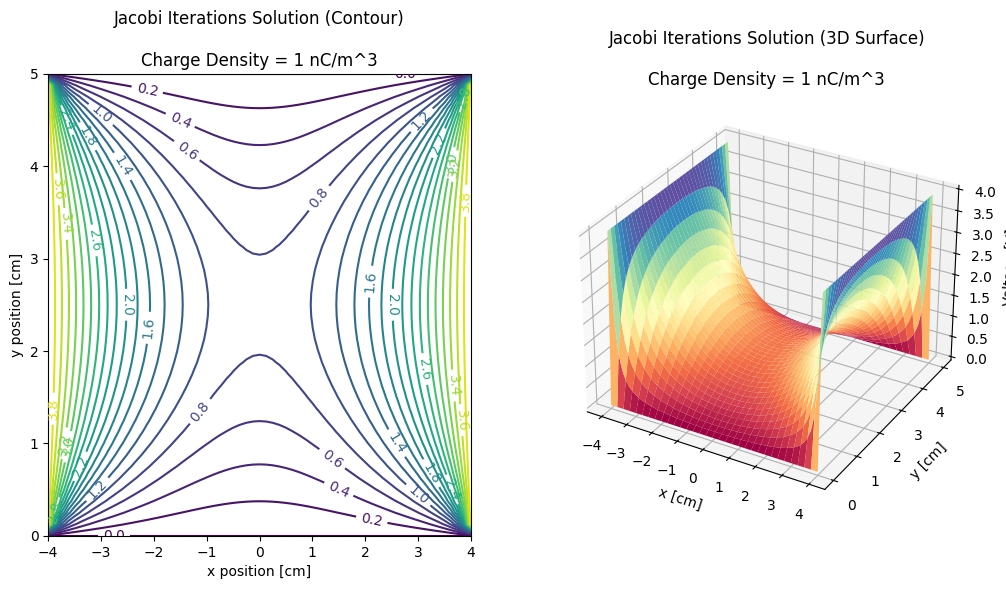

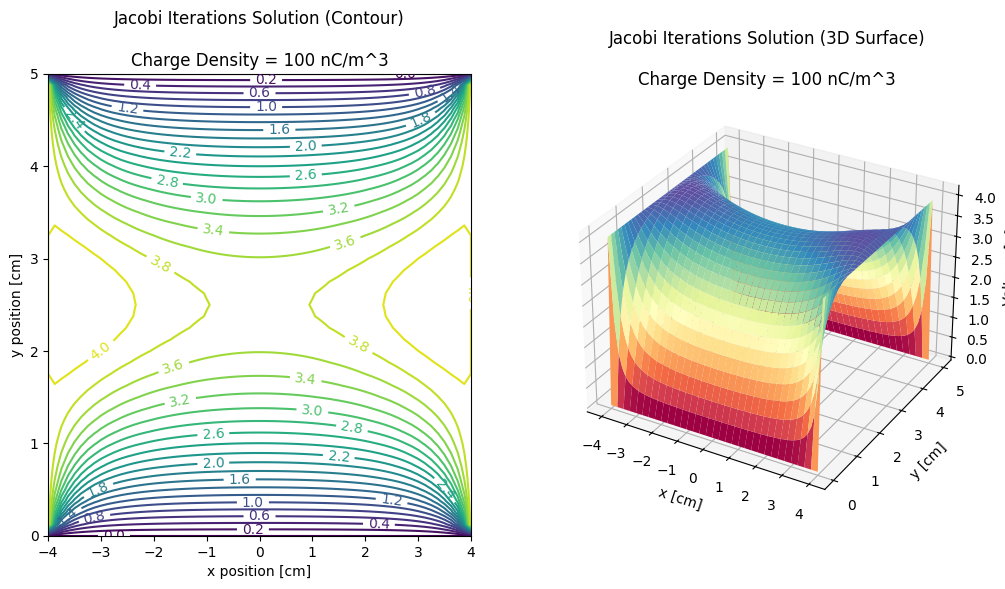

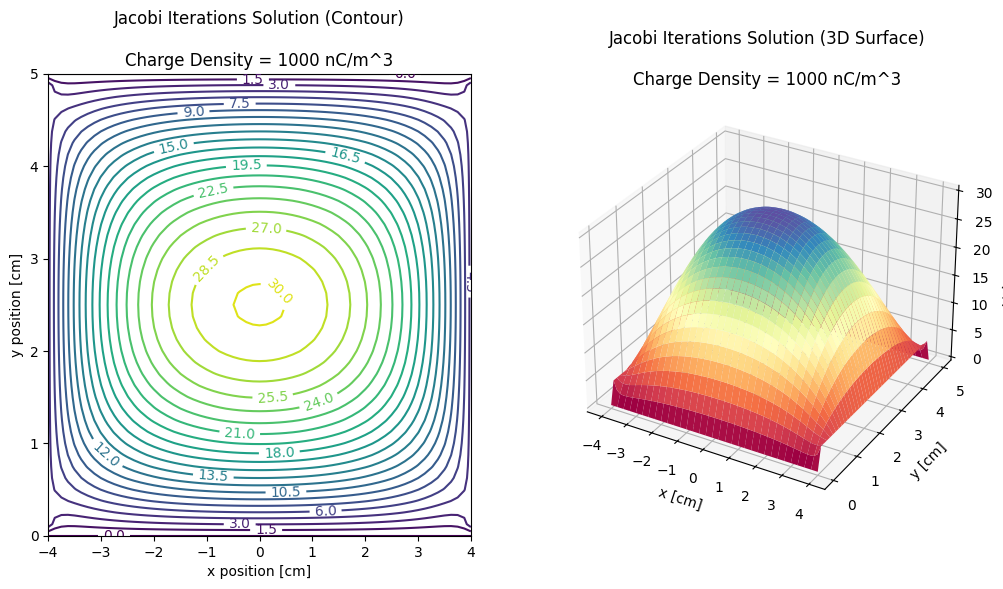

In [4]:
#1nC/m^3 = 1e-9 C/m^3 = 1e-15 C/cm^3
X3, Y3, V3 = jacobi(1e-15)

#100nC/m^3 = 100e-9 C/m^3 = 100e-15 C/cm^3
X4, Y4, V4 = jacobi(100e-15)

#1000nC/m^3 = 1000e-9 C/m^3 = 1000e-15 C/cm^3
X5, Y5, V5 = jacobi(1000e-15)

### Question 4: [8 pts]

Repeat question 3 with $𝜌 = 100 nC/m^3$ using a direct matrix solution rather than Jacobi iteration. Compare your result with the result from question 2.

The Matrix shown below matches the array shown in Slide 11 of the notes.
The value 2 was selected for 'c', 3 for 'a', and 4 for 'g'

This was done to prove that the matrix function is working correctly.

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 3. 2. 3. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 4. 0. 0. 3. 2. 3. 0. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 4. 0. 0. 3. 2. 3. 0. 0. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 4. 0. 0. 3. 2. 3. 0. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

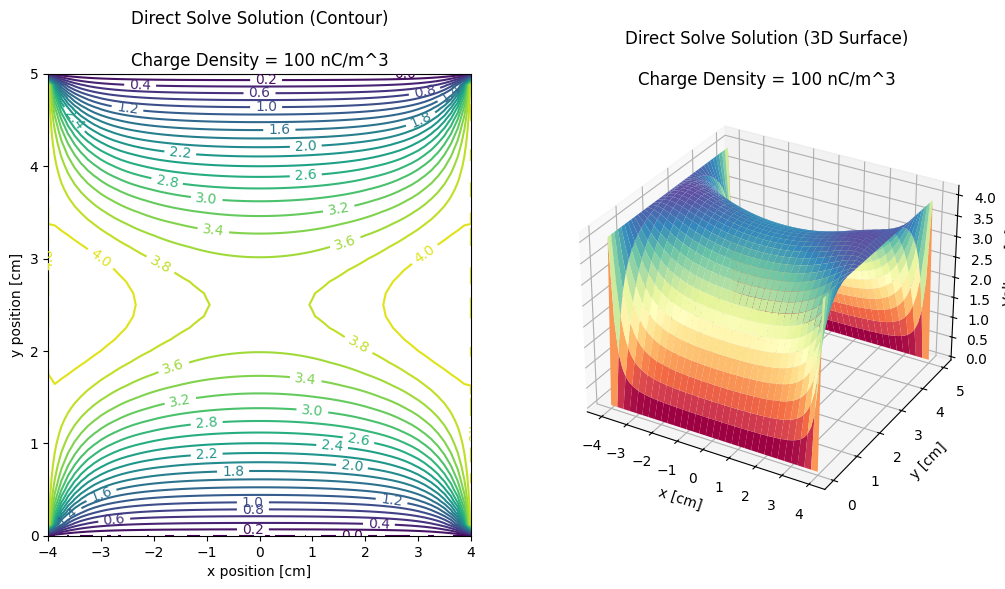

The maxiumum difference between the two methods was 5.293543e-13, or 1.278905e-11%.
The average difference between the two methods was 1.320670e-14, or 4.846820e-13%.


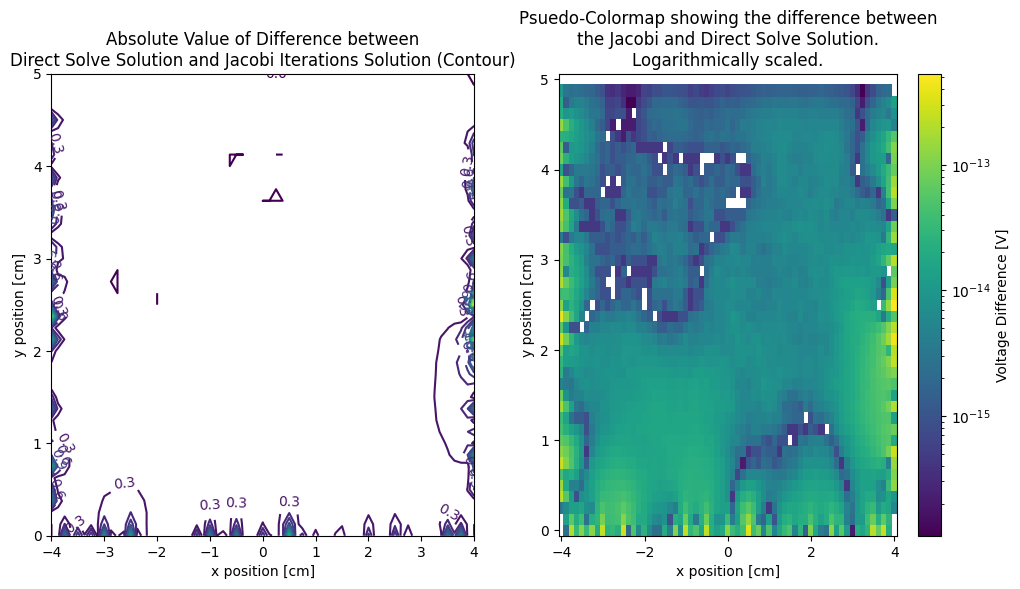

In [ ]:
def matrix(num_x, num_y, testing = False):

    '''This function creates a (n*m) x (n*m) matrix that satisfies the Dirchlet Boundary Equations matrix. Using the desired
    x and y dimensions for n and m respectively.
    
    This function has a "testing" mode to see if the matrix generation is working as expected (requiring much 
    more reasonable x.y numbers, like (4x4)x(4x4) = 16x16).

    -----------------------------------------------------------------------------------------------------------------
    Parameters: num_x, num_y (integers) - used to determine size of matrix. testing = True or False for testing mode.
    Returns: A - 2D numpy array
    '''

    #Step 1: calculate a, c and g
    if testing == True:
        c = 2.0
        a = 3.0
        g = 4.0
    
    else:
        
        dx = 8/(num_x-1) #finds dx in cm
        dy = 5/(num_y-1) #finds dy in cm

        #formulas for a, g and c from lecture notes
        a = 1.0 / dx**2
        g = 1.0 / dy**2
        c = -2.0 *a - 2.0*g

    #Step 2: create the d/dx^2 array (size num_x*num_x)
    A_1D = np.identity(num_x)
    A_1D[0, 0:2] = [c, a]
    A_1D[-1, -2:] = [a, c]
    for i in range(1, num_x-1):
        A_1D[i, i] = c
        A_1D[i, i-1] = a
        A_1D[i, i+1] = a
    
    #Step 3: Tile the d/dx^2 array into the full array (size num_x*num_y by num_x*num_y)
    A = np.zeros((num_x*num_y, num_x*num_y))
    for i in range(num_y):
        A[i*num_x:i*num_x+num_x, i*num_x:i*num_x+num_x] = A_1D
    
    #this for loop enforces periodic boundaries on each tile
    for i in range(num_y):
        for j in range(num_x):
            #Connect the left and right columns in the x-direction (periodic) 
            left_index = i * num_x + j 
            right_index = i * num_x + (j + 1) % num_x  # Modulus ensures periodicity
            A[left_index, right_index] = a
            A[right_index, left_index] = a
            
    #Step 4/5: Insert the d/dy^2 bands with periodicity
    for i in range(num_y):
        for j in range(num_x):

            #Inserting top g band
            row_index = (i * num_x + j) 
            column_index = ((i + 1) % num_y * num_x + j)  # Wrap around for periodicity
            A[row_index, column_index] = g

            #Inserting bottom g band
            row_index = (i*num_x + j + num_x) % (num_x*num_y)
            column_index = (i*num_x+j)
            A[row_index, column_index] = g
    
    #Step 6: Dirchlet Boundaries  
    A[:num_x, :] = 0  #Zero out rows
    np.fill_diagonal(A[:num_x, :num_x], 1)  #Set diagonal to 1
    
    # Last rows (bottom boundary)
    A[-num_x:, :] = 0  # Zero out rows
    np.fill_diagonal(A[-num_x:, -num_x:], 1)  #Set diagonal to 1

    #Replace rows for left and right edges of middle rows
    for i in range(1, num_y - 1):
        left_edge = i * num_x  # Left edge index
        right_edge = i * num_x + num_x - 1  # Right edge index

        A[left_edge, :] = 0  # Zero out row for left edge
        A[left_edge, left_edge] = 1  # Set diagonal to 1

        A[right_edge, :] = 0  # Zero out row for right edge
        A[right_edge, right_edge] = 1  # Set diagonal to 1
    
    return A

def direct():
    
    '''Takes a final approach to solving the same problem. We will construct a matrix A with direchlet boundary conditions,
    and create a (flattened) array b with the potential boundary conditions and charge density. We then solve the equation Ax=b to get our
    voltage values.
    
    This function also makes a contour plot and 3D surface plot to visualize the determined values. The XYZ values are returned
    for later use.
    -----------------------------------------------------------------------------------------------------------------
    Parameters: None
    Returns: X and Y meshgrids, and Voltage values (tuple)

    '''
    #constants
    charge = 100e-15 #100nC/m^3 = 100e-9 C/m^3 = 100e-15 C/cm^3
    E_0 = 8.854e-14  #8.854e-14 F/cm

    #going to keep using same num_x and num_y as before for consistency
    num_x = 65
    num_y = 41
    
    #initializing arrays
    x_values = np.linspace(-4,4,num_x)
    y_values = np.linspace(0,5,num_y)
    X, Y = np.meshgrid(x_values, y_values)
    
    #Construct RHS matrix b
    b = np.zeros((num_y,num_x))

    #Set boundary conditions and charge density
    b[:,:]= -charge/E_0
    b[:,0]  = 4
    b[:,-1] = 4
    b[-1,:]  = 0
    b[0,:] = 0

    #Flatten b, row major order
    bflat=b.flatten('C')

    A = matrix(num_x, num_y, testing=False)
    
    #Solve Ax=b 
    V = np.linalg.solve(A, bflat)
    V = np.reshape(V, (num_y, num_x), order='C')
    
    #Create subplots
    fig = plt.figure(figsize=(12, 6))

    #Plot contour in the first subplot
    ax1 = fig.add_subplot(121)
    anal = ax1.contour(X, Y, V, levels=25)
    ax1.clabel(anal, inline=True, fontsize=10)
    ax1.set_xlabel('x position [cm]')
    ax1.set_ylabel('y position [cm]')
    ax1.set_title('Direct Solve Solution (Contour)\n\nCharge Density = %i nC/m^3'%(charge*(10**15)))

    #Plot 3D surface in the second subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(X, Y, V, cmap='Spectral', linewidth=0, antialiased=True)
    ax2.set_xlabel('x [cm]')
    ax2.set_ylabel('y [cm]')
    ax2.set_zlabel('Voltage [V]')
    ax2.set_title('Direct Solve Solution (3D Surface)\n\nCharge Density = %i nC/m^3'%(charge*(10**15)))
    plt.show()
    return X, Y, V
    
#Testing to ensure output matrix matches Slide 9 of Notes
A = matrix(4, 4, testing = True)
print("The Matrix shown below matches the array shown in Slide 11 of the notes.")
print("The value 2 was selected for 'c', 3 for 'a', and 4 for 'g'\n")
print("This was done to prove that the matrix function is working correctly.\n")
print(A,'\n')

X6, Y6, V6, = direct()
comparison(X4, X6, Y4, Y6, V4, V6, question='q4')